In [1]:
import torch
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import _pickle as cPickle
import gzip

batch_size = 20
num_epochs = 10

In [2]:
def load_data():
    # Загрузка данных из gzip-файла
    f = gzip.open('/Users/ismagil/Downloads/ВведениеВМашинноеобучение/МНС/data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = cPickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    # Загрузка данных и преобразование формата
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))

    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))

    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))

    return (training_data, validation_data, test_data)

def vectorized_result(j):
    # Преобразование метки в формат "one-hot"
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
# Загрузка данных
train_data, val_data, test_data = load_data()

Количество снимков: 50000


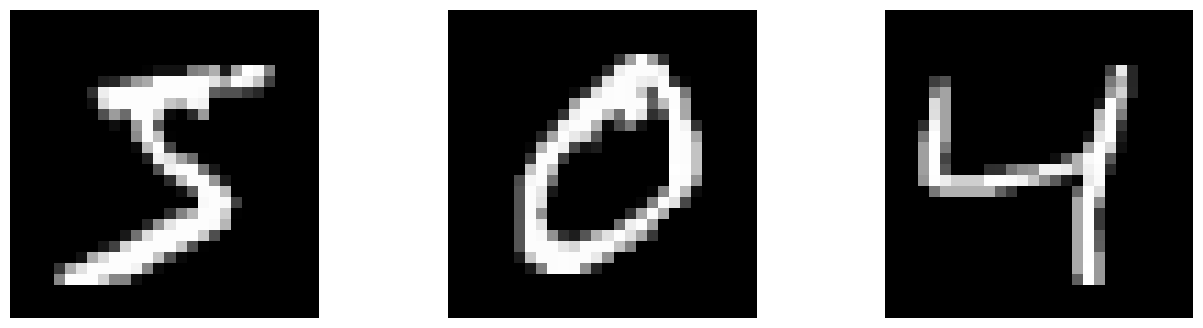

Размеры снимков W: 28, H: 28


In [4]:
# Отображение данных из датасета
print(f"Количество снимков: {len(train_data[0])}")

fig = plt.figure(figsize=(16, 4))
for i, data_point in enumerate(train_data[0][:3]):

    fig.add_subplot(1,3,i+1)
    plt.imshow(data_point.reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

SIZE_Y, SIZE_X = len(train_data[0][0].reshape(28, 28)), len(train_data[0][0].reshape(28, 28))
print(f"Размеры снимков W: {SIZE_X}, H: {SIZE_Y}")

In [5]:
print(f"Количество снимков в тренировочном наборе: {len(train_data[0])}")
print(f"Количество снимков в тестовом наборе: {len(test_data[0])}")
print(f"Количество снимков в валидационном наборе: {len(val_data[0])}")

Количество снимков в тренировочном наборе: 50000
Количество снимков в тестовом наборе: 10000
Количество снимков в валидационном наборе: 10000


In [6]:
# Модель сверточной нейронно сети из двух сверточных слоев
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Первый полносвязный слой: вход 32 * SIZE_Y//4 * SIZE_X//4
        # SIZE_Y или SIZE_X делим на размер размер ядра пуллинга ** кол-во пулингов
        self.fc1 = nn.Linear(32 * (SIZE_Y//4) * (SIZE_X//4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = CNN()                                       # Создание модели CNN
criterion = nn.CrossEntropyLoss()                   # Функция потерь
optimizer = torch.optim.Adam(model.parameters(),    # Оптимизатор
                            lr=0.0001)              

In [8]:
# преобразование в тензоры PyTorch
train_data_tensor = torch.Tensor(train_data[0]).unsqueeze(1)
train_labels_tensor = torch.LongTensor(train_data[1])

# объединение входных данных и меток
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
# Создание DataLoader для тестового набора данных
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# преобразование в тензоры PyTorch
test_data_tensor = torch.Tensor(test_data[0]).unsqueeze(1)
test_labels_tensor = torch.LongTensor(test_data[1])

# объединение входных данных и меток
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
# Создание DataLoader для тестового набора данных
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
train_loss, train_acc, test_loss, test_acc = [], [], [], []

for epoch in range(num_epochs):

    model.train() # Перевод модели в режим обучения
    correct_preds, current_loss = 0, 0.0

    # Цикл обучения по тренировочным данным
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.view(-1, 1, 28, 28)
        outputs = model(inputs)  # Проход данных через модель

        # Рассчет потерь и обратное распространение
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += float(loss)

        _, predicted = torch.max(outputs, 1)
        correct_preds += sum([1 for p, l in zip(predicted, labels) if p == l])

    # Рассчет точности на тренировочных данных
    accuracy = correct_preds / len(train_data[1])

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {current_loss / len(train_loader)}, Accuracy: {accuracy * 100:.2f}%')

    train_loss.append(current_loss / len(train_loader))
    train_acc.append(accuracy)

    model.eval() # Перевод модели в режим оценки
    test_loss_val, correct_test_preds = 0.0, 0

    # Оценка модели на тестовых данных без расчета градиентов
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.view(-1, 1, 28, 28)
            test_outputs = model(test_inputs)
            test_loss_val += float(criterion(test_outputs, test_labels))

            _, predicted_test = torch.max(test_outputs, 1)
            correct_test_preds += sum([1 for p, l in zip(predicted_test, test_labels) if p == l])

    # Рассчет точности на тестовых данных
    test_accuracy = correct_test_preds / len(test_data[1])

    test_loss.append(test_loss_val / len(test_loader))
    test_acc.append(test_accuracy)

Epoch 1/10, Loss: 0.491446305244416, Accuracy: 85.97%
Epoch 2/10, Loss: 0.15513075083717703, Accuracy: 95.35%
Epoch 3/10, Loss: 0.09934090896779671, Accuracy: 97.05%
Epoch 4/10, Loss: 0.07548067595262546, Accuracy: 97.74%
Epoch 5/10, Loss: 0.061870436329231594, Accuracy: 98.11%
Epoch 6/10, Loss: 0.05222172651551664, Accuracy: 98.42%
Epoch 7/10, Loss: 0.04496610066739377, Accuracy: 98.65%
Epoch 8/10, Loss: 0.039384745222260244, Accuracy: 98.82%
Epoch 9/10, Loss: 0.03514676735828689, Accuracy: 98.94%
Epoch 10/10, Loss: 0.03143350228003692, Accuracy: 99.07%


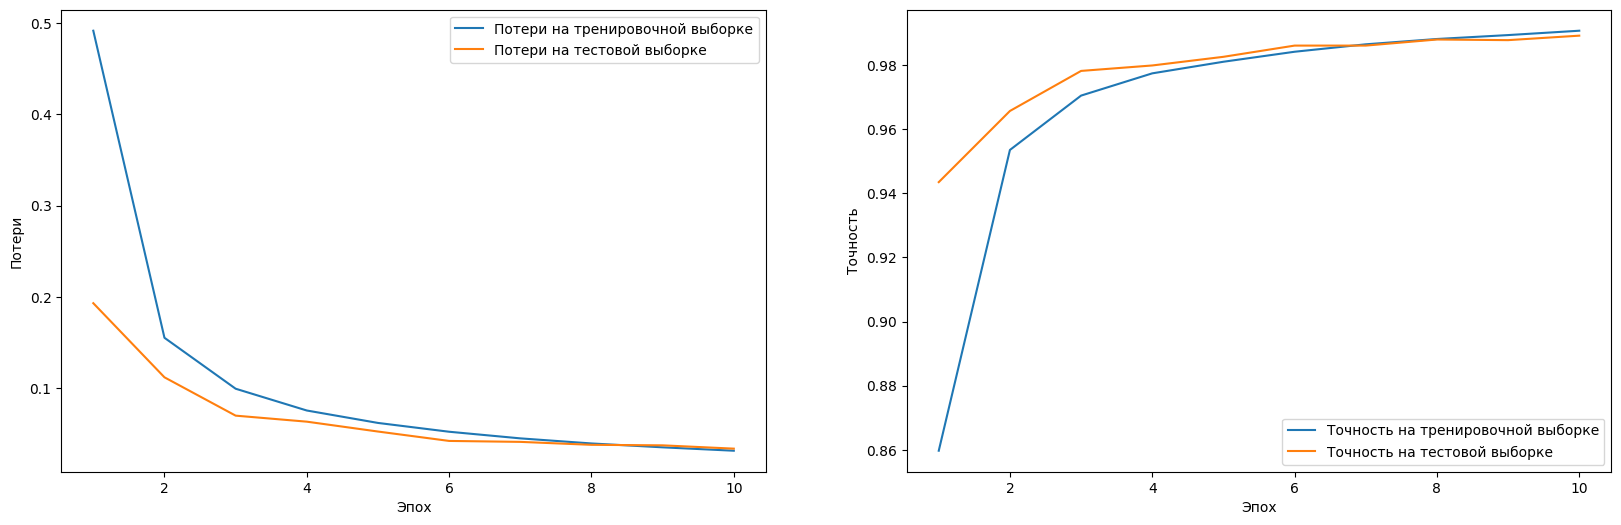

In [10]:
plt.figure(figsize=(20, 6))

# вывод графиков точности и потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label='Потери на тренировочной выборке')
plt.plot(range(1, num_epochs + 1), test_loss, label='Потери на тестовой выборке')
plt.xlabel('Эпох')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, label='Точность на тренировочной выборке')
plt.plot(range(1, num_epochs + 1), test_acc, label='Точность на тестовой выборке')
plt.xlabel('Эпох')
plt.ylabel('Точность')
plt.legend()

plt.show()

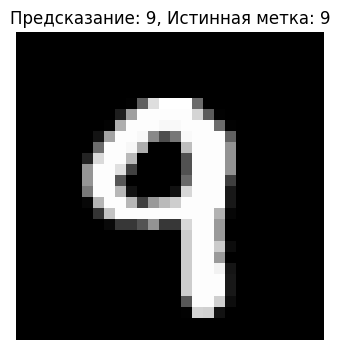

In [11]:
# Cлучайное изображение для теста
rnd_idx = np.random.randint(0, len(test_data[0]) - 1)
img, lbl = test_data[0][rnd_idx], test_data[1][rnd_idx]

img_tensor = torch.Tensor(img).unsqueeze(0).unsqueeze(1)
img_tensor = img_tensor.view(-1, 1, 28, 28)

# Получаем предсказание от модели
model.eval()
with torch.no_grad():
    pred = model(img_tensor)
    _, pred_lbl = torch.max(pred, 1)

# Выводим результаты
plt.figure(figsize=(4, 4))
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.title(f'Предсказание: {int(pred_lbl)}, Истинная метка: {lbl}')
plt.axis('off')
plt.show()
